# Analyzing document layout
1. Get text bounding boxes (DIA with pretrained model)
2. Extract text inside bounding boxes (OCR with Tessaract engine)
3. Structure output and extract entities from structured data (NER)

Tutorial: https://towardsdatascience.com/analyzing-document-layout-with-layoutparser-ed24d85f1d44

To do:
- [x] put scans on Great Lakes Turbo (`/nfs/turbo/isr-jtalexnonsen/images`)
- [ ] set up Tesseract-OCR engine on Great Lakes (submitted help ticket, 5/19)
- [ ] tune best layout model so that each bounding box is one text field

Prerequisites for running on Great Lakes
- Load modules (Python version, GCC compiler)
- Install layoutparser, torchvision, detectron pretrained models, and OCR utility

In [1]:
# module load gcc/8.2.0
# module load python3.8-anaconda/2020.07
# !pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2" --user
# !pip install layoutparser[ocr] --user

In [2]:
import layoutparser as lp
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import cv2

Load a sample image from Turbo store. Options:
- all, nested hierarchy (`/nfs/turbo/isr-jtalexnonsen/images`)
- all, flattened hierarchy (`/nfs/turbo/isr-jtalexnonsen/flat_images`)
- sample scans (`/nfs/turbo/isr-jtalexnonsen/sample_scans`)

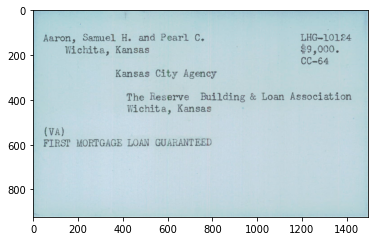

In [3]:
image_files = sorted(glob.glob('/nfs/turbo/isr-jtalexnonsen/sample_scans'+'/*.jpg'))
image = cv2.imread(image_files[0])
plt.imshow(image);

Detect layout
* [Model catalog](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html#model-catalog): Prima layout seemns to be the best approximation for our irregular index card layout
    
Inspect bounding boxes detected on scan
- coordinates of the bounding box (x1, y1, x2, y2) of each detected layout
- type of detected layout (i.e text, image, table, list, or title)
- id of detected layout
- text inside each detected layout
- confidence score of each detected layout

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/home/slafia/.local/lib/python3.8/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/slafia/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-de

Layout(_blocks=[TextBlock(block=Rectangle(x_1=361.6533508300781, y_1=569.1644287109375, x_2=818.7578735351562, y_2=609.4520263671875), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9489331841468811), TextBlock(block=Rectangle(x_1=192.75941467285156, y_1=572.1420288085938, x_2=431.7569274902344, y_2=608.3895874023438), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9181950688362122), TextBlock(block=Rectangle(x_1=78.2974853515625, y_1=566.793701171875, x_2=612.7142944335938, y_2=610.3746337890625), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.6648924946784973), TextBlock(block=Rectangle(x_1=0.0, y_1=49.2252082824707, x_2=1174.490478515625, y_2=333.7599182128906), text=None, id=None, type=ImageRegion, parent=None, next=None, score=0.5900179147720337), TextBlock(block=Rectangle(x_1=1184.549560546875, y_1=44.08863830566406, x_2=1425.22119140625, y_2=267.8226318359375), text=None, id=None, type=OtherRegion, parent=None, ne

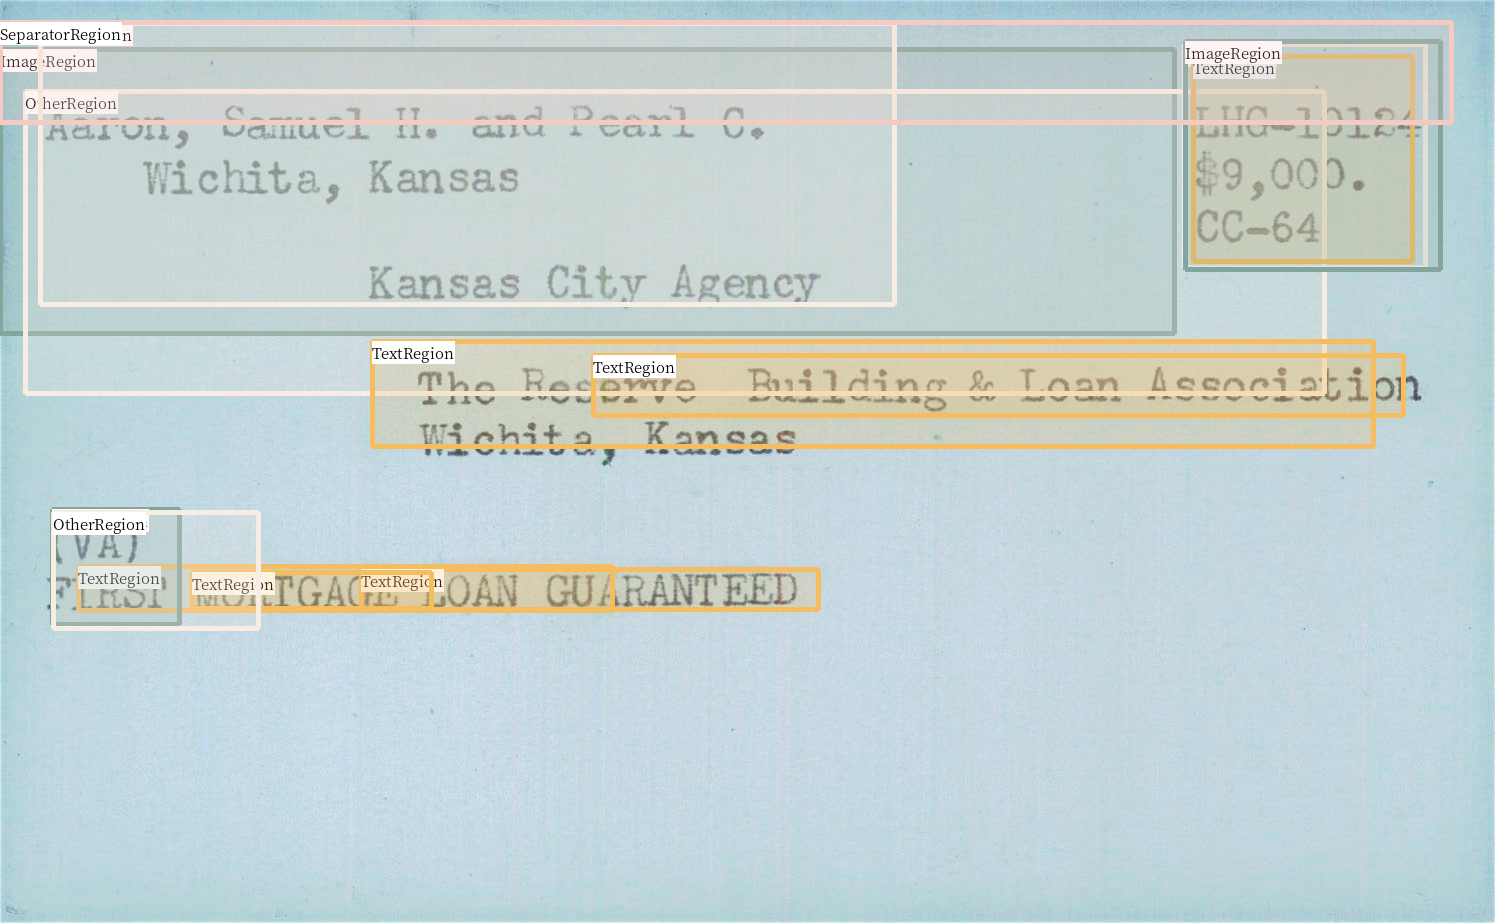

In [4]:
model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', # configuration path for pretrained model
                                 label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"}, # optional: mapping from ids of model prediction to label
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5] # optional: confidence threshold for bounding boxes of detected layout
)

layout_result = model.detect(image)
print(layout_result)
lp.draw_box(image, layout_result, box_width=5, box_alpha=0.2, show_element_type=True) # adjust box display settings

Optional: Get specific text blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=361.6533508300781, y_1=569.1644287109375, x_2=818.7578735351562, y_2=609.4520263671875), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9489331841468811), TextBlock(block=Rectangle(x_1=192.75941467285156, y_1=572.1420288085938, x_2=431.7569274902344, y_2=608.3895874023438), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9181950688362122), TextBlock(block=Rectangle(x_1=78.2974853515625, y_1=566.793701171875, x_2=612.7142944335938, y_2=610.3746337890625), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.6648924946784973), TextBlock(block=Rectangle(x_1=372.2295837402344, y_1=341.7650451660156, x_2=1373.1510009765625, y_2=446.42230224609375), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.2211901694536209), TextBlock(block=Rectangle(x_1=1193.261962890625, y_1=56.36268997192383, x_2=1412.56396484375, y_2=261.814697265625), text=None, id=None, type=TextRegion, p

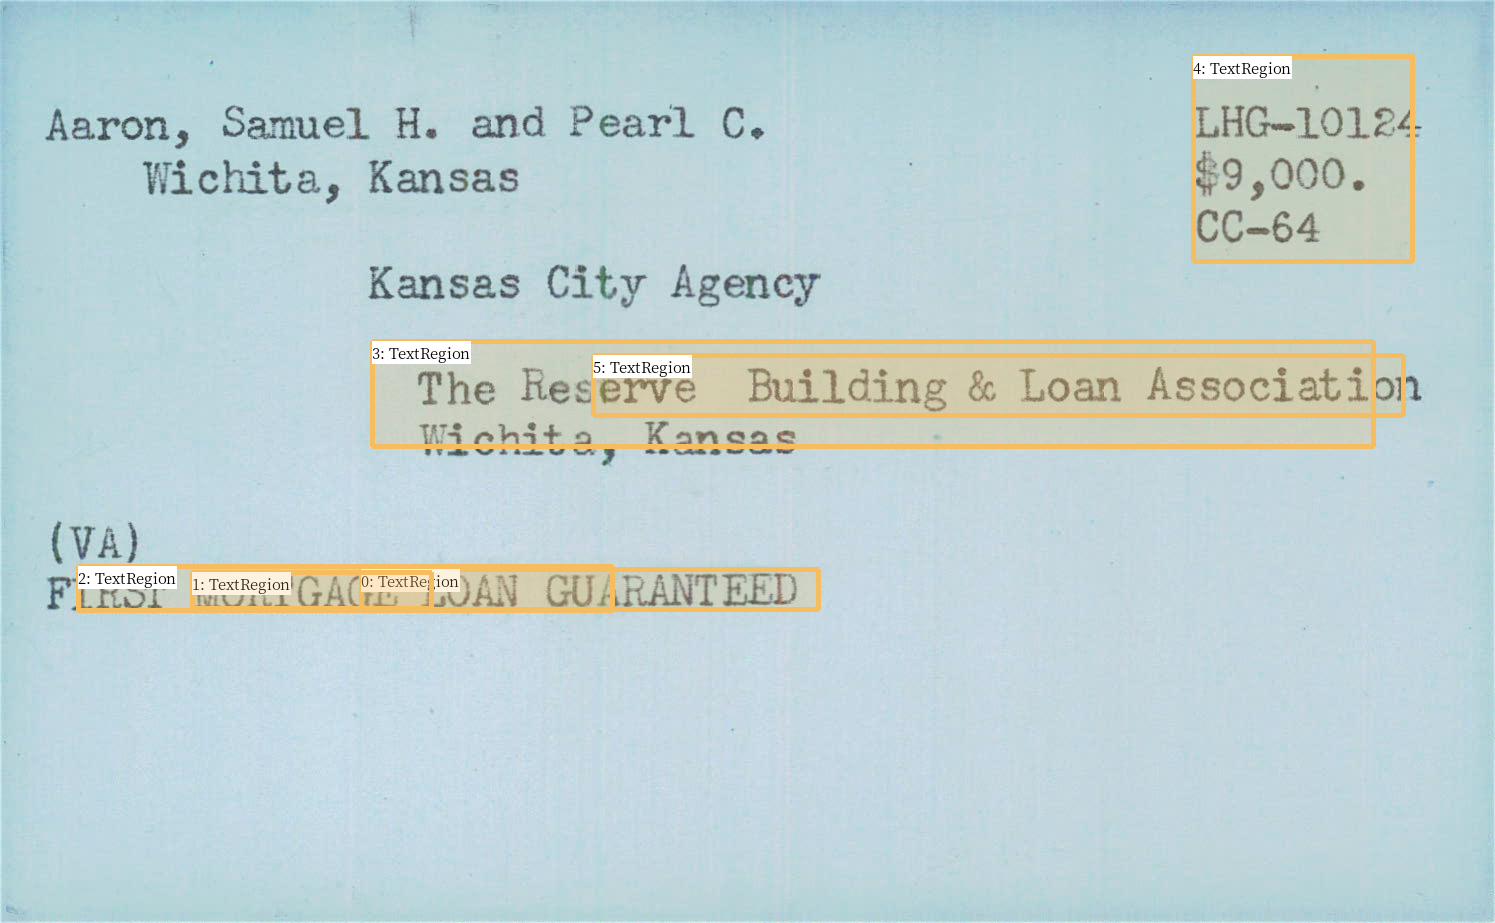

In [5]:
text_blocks = lp.Layout([b for b in layout_result if b.type=='TextRegion'])
print(text_blocks)
lp.draw_box(image, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

To do: install [Tesseract](https://tesseract-ocr.github.io/tessdoc/Installation.html) engine and trained data on Great Lakes

In [6]:
# Sort text for OCR engine to extract sequentially
# image_width = len(image[0])

# Sort element ID of the left column based on y1 coordinate
# left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(image)
# left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks
# left_blocks.sort(key = lambda b:b.coordinates[1])

# Sort element ID of the right column based on y1 coordinate
# right_blocks = [b for b in text_blocks if b not in left_blocks]
# right_blocks.sort(key = lambda b:b.coordinates[1])

# Sort the overall element ID starts from left column
# text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [7]:
# ocr_agent = lp.TesseractAgent(languages='eng')

In [8]:
# for block in text_blocks:

#     # Crop image around the detected layout
#     segment_image = (block
#                        .pad(left=15, right=15, top=5, bottom=5)
#                        .crop_image(image))
    
#     # Perform OCR
#     text = ocr_agent.detect(segment_image)

#     # Save OCR result
#     block.set(text=text, inplace=True)